In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

%load_ext autoreload
%autoreload 2

In [4]:
image_0 = imread('cat.jpg')

# PCA compression and decompression

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-17..276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-16..278].


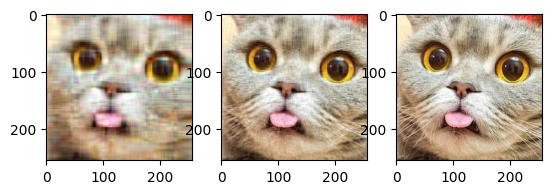

In [5]:
def pca_compression(image, p=30):

    pca_compressed = []
    for channel in np.transpose(image, (2,0,1)):
        ch_means = np.mean(channel, axis=0)
        ch_zero_centered = channel - ch_means
        ch_covariance = np.cov(ch_zero_centered.T)
        _, ch_eig_vectors = np.linalg.eigh(ch_covariance)
        pca_compressed.append((ch_eig_vectors[:,::-1][:,:p], ch_zero_centered @ ch_eig_vectors[:,::-1][:,:p], ch_means))

    return pca_compressed

def pca_decompression(pca_compressed):
    return np.dstack([pca_projection @ eig_vectors.T + column_means for (eig_vectors, pca_projection, column_means) in pca_compressed])


fig, ax = plt.subplots(1, 3)
ax[0].imshow(pca_decompression(pca_compression(image_0, 10)).astype(int))
ax[1].imshow(pca_decompression(pca_compression(image_0, 30)).astype(int))
ax[2].imshow(pca_decompression(pca_compression(image_0, 100)).astype(int))

# JPEG

RGB to YCbCr

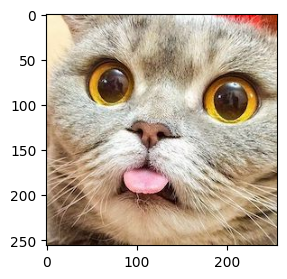

In [34]:
def rgb_to_ycbcr(rgb):
    return (np.array([0, 128, 128]) + rgb @ np.array((
        (.299, .587, .114),
        (-.1687, -.3313, .5),
        (.5, -.4178, -.0813)
    )).T)

def ycbcr_to_rgb(ycbcr):
    return ((ycbcr - np.array([0, 128, 128])) @ np.array((
        (1, 0, 1.402),
        (1, -.34414, -.71414),
        (1, 1.77, 0)
    )).T)

plt.figure(figsize=(3,3))
plt.imshow(ycbcr_to_rgb(rgb_to_ycbcr(image_0)).astype(int))

Blur CbCr vs Blur Y

/var/folders/4b/m8ykh5795flg_b6s_rlsz5h40000gn/T/ipykernel_24828/2555672809.py:6: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  cbcr_blurred = ycbcr * [1,0,0] + scipy.ndimage.filters.gaussian_filter(ycbcr[:,:,1], 10, radius=10)[:,:,None] * [0,1,0] + scipy.ndimage.filters.gaussian_filter(ycbcr[:,:,2], 10, radius=10)[:,:,None] * [0,0,1]
/var/folders/4b/m8ykh5795flg_b6s_rlsz5h40000gn/T/ipykernel_24828/2555672809.py:7: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  y_blurred = ycbcr * [0,1,1] + scipy.ndimage.filters.gaussian_filter(ycbcr[:,:,0], 10, radius=10)[:,:,None] * [1,0,0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-65..277].
Clipping input data to

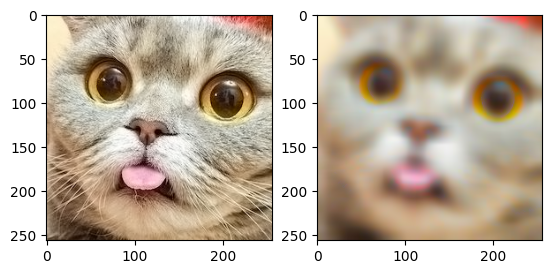

In [36]:
import scipy.ndimage

fig, ax = plt.subplots(1,2)

ycbcr = rgb_to_ycbcr(image_0)
cbcr_blurred = ycbcr * [1,0,0] + scipy.ndimage.filters.gaussian_filter(ycbcr[:,:,1], 10, radius=10)[:,:,None] * [0,1,0] + scipy.ndimage.filters.gaussian_filter(ycbcr[:,:,2], 10, radius=10)[:,:,None] * [0,0,1]
y_blurred = ycbcr * [0,1,1] + scipy.ndimage.filters.gaussian_filter(ycbcr[:,:,0], 10, radius=10)[:,:,None] * [1,0,0]
ax[0].imshow(ycbcr_to_rgb(cbcr_blurred).astype(int))
ax[1].imshow(ycbcr_to_rgb(y_blurred).astype(int))


JPEG encoding / decoding

In [39]:
import scipy.ndimage
import numpy as np

y_quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

color_quantization_matrix = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

def downsample(component):
    return scipy.ndimage.gaussian_filter(component, 1, radius=10) [::2, ::2]

def dct(block):
    alpha = lambda x: np.sqrt(.5) if x == 0 else 1
    dct_one_coeff = lambda u, v: .25 * alpha(u) * alpha(v) * np.sum(block * np.cos(1/16 * np.pi * u * (2 * np.arange(8)[:, None] + 1)) * np.cos(1/16 * np.pi * v * (2 * np.arange(8)[None, :] + 1)))

    u, v = np.indices((8, 8))
    return np.vectorize(dct_one_coeff)(u, v)

def quantize(block, quantization_matrix):
    return np.round(block / quantization_matrix)

def scale_factor(quality=50):
    if quality < 50: return 5000/quality
    if quality <= 99: return 200-2*quality
    return 1

def own_quantization_matrix(default_quantization_matrix, quality=50):
    scale_factor = (quality<50)*(5000/quality) + (quality >= 50)*2*(100-quality)
    return np.clip(np.floor((50 + scale_factor * default_quantization_matrix)/100), 1, None)

zig_zag_order = (
    0, 1, 8, 16, 9, 2, 3, 10,
    17, 24, 32, 25, 18, 11, 4, 5,
    12, 19, 26, 33, 40, 48, 41, 34,
    27, 20, 13, 6, 7, 14, 21, 28,
    35, 42, 49, 56, 57, 50, 43, 36,
    29, 22, 15, 23, 30, 37, 44, 51,
    58, 59, 52, 45, 38, 31, 39, 46,
    53, 60, 61, 54, 47, 55, 62, 63
)

def zigzag(block):
    return block[np.unravel_index((zig_zag_order), (8, 8))]

def compress(zig_zag_list):
    i_of_zero_start = []
    i_of_zero_end = []
    was_zero = False
    for i, list_item in enumerate(zig_zag_list):
        if not (was_zero) and (list_item == 0):
            i_of_zero_start.append(i)
            i_of_zero_end.append(i)
            was_zero = True
        elif was_zero and (list_item == 0): i_of_zero_end[-1] = i
        elif was_zero and (list_item != 0): was_zero = False
    
    zig_zag_single_zeros = zig_zag_list[(zig_zag_list != 0) | np.insert(np.diff(zig_zag_list).astype(np.bool), 0, True)]
    return np.insert(zig_zag_single_zeros, np.where(zig_zag_single_zeros==0)[0]+1, 1 + np.array(i_of_zero_end) - np.array(i_of_zero_start)).astype(int)

def divide_into_blocks(component):
    h, w = component.shape
    padded_h, padded_w = (np.ceil(np.array(component.shape)/8)*8).astype(int)
    return (np.pad(component, ((0, padded_h-h), (0, padded_w-w)), mode='edge').reshape(padded_h // 8, 8, -1, 8)
                 .transpose(0, 2, 1, 3)
                 .reshape(-1, 8, 8))

def jpeg_encode(image, quality=50):
    ycbcr = rgb_to_ycbcr(image).astype(int)
    Y, Cb, Cr = ycbcr[:,:,0], ycbcr[:,:,1], ycbcr[:,:,2]
    Y_blocks, Cb_blocks, Cr_blocks = divide_into_blocks(Y)-128, divide_into_blocks(downsample(Cb))-128, divide_into_blocks(downsample(Cr))-128
    return [
        [compress(zigzag(quantize(dct(block), own_quantization_matrix(y_quantization_matrix, quality)))) for block in Y_blocks],
        [compress(zigzag(quantize(dct(block), own_quantization_matrix(color_quantization_matrix, quality)))) for block in Cb_blocks],
        [compress(zigzag(quantize(dct(block), own_quantization_matrix(color_quantization_matrix, quality)))) for block in Cr_blocks]
    ]

def inverse_compress(compressed_list):
    
    zero_indices = np.array(np.where(compressed_list==0)[0])
    zero_counts = compressed_list[zero_indices+1]
    cleaned_counts_list = np.delete(compressed_list, zero_indices+1)
    return np.hstack([np.hstack([list_split, np.zeros(np.append(zero_counts, 1)[i]-1)]) \
               for i, list_split in enumerate(np.split(cleaned_counts_list, np.where(cleaned_counts_list == 0)[0]))]).astype(int)

def inverse_zigzag(arr):
    return arr[np.argsort(zig_zag_order)].reshape(8,8)

def inverse_quantize(block, quantization_matrix):
    return block * quantization_matrix

def inverse_dct(block):

    alpha = lambda x: np.where(x==0, np.sqrt(.5), 1)
    dct_one_coeff = lambda x, y: .25 * np.sum(alpha(np.arange(8)[:,None]) * alpha(np.arange(8)[None,:]) * block * np.cos(1/16 * np.pi * np.arange(8)[:,None] * (2*x+1)) * np.cos(1/16 * np.pi * np.arange(8)[None,:] * (2*y+1)))

    x, y = np.indices((8, 8))
    return np.round(np.vectorize(dct_one_coeff)(x, y))

def upsample(component):
    return component.repeat(2, axis=0).repeat(2, axis=1)

def join_blocks(blocks, shape):
    padded_h, padded_w = (np.ceil(np.array(shape) / 8) * 8).astype(int)
    return blocks.reshape(padded_h//8, padded_w//8, 8, 8).transpose(0, 2, 1, 3).reshape(padded_h, padded_w)[:shape[0], :shape[1]]

def jpeg_decode(encoded_image, result_shape, quality=50):
    Y_encoded, Cb_encoded, Cr_encoded = encoded_image
    Y_blocks = np.array([inverse_dct(inverse_quantize(inverse_zigzag(inverse_compress(block)), own_quantization_matrix(y_quantization_matrix, quality))) for block in Y_encoded]) + 128
    Cb_blocks = np.array([inverse_dct(inverse_quantize(inverse_zigzag(inverse_compress(block)), own_quantization_matrix(color_quantization_matrix, quality))) for block in Cb_encoded]) + 128
    Cr_blocks = np.array([inverse_dct(inverse_quantize(inverse_zigzag(inverse_compress(block)), own_quantization_matrix(color_quantization_matrix, quality))) for block in Cr_encoded]) + 128
    ycbcr = np.dstack((
        join_blocks(Y_blocks, result_shape),
        upsample(join_blocks(Cb_blocks, np.array(result_shape)//2)),
        upsample(join_blocks(Cr_blocks, np.array(result_shape)//2)),
    ))
    return np.clip(ycbcr_to_rgb(ycbcr), 0, 255).astype(np.uint8)

def jpeg_visualize(image, quality=50):
    plt.imshow(jpeg_decode(jpeg_encode(image, quality), image.shape[:2], quality))

<Figure size 1500x1000 with 0 Axes>

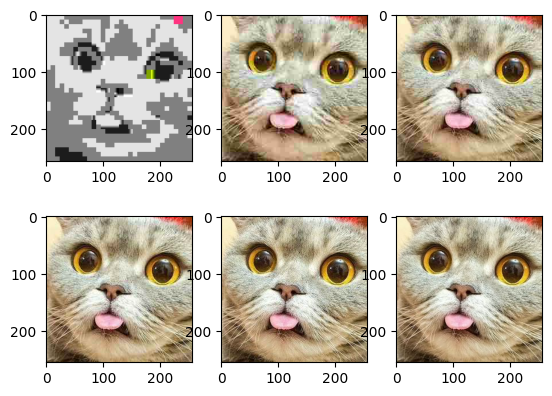

In [40]:
plt.figure(figsize=(15,10))
fig, ax = plt.subplots(2, 3)
ax[0, 0].imshow(jpeg_decode(jpeg_encode(image_0, 1), image_0.shape[:2], 1))
ax[0, 1].imshow(jpeg_decode(jpeg_encode(image_0, 10), image_0.shape[:2], 10))
ax[0, 2].imshow(jpeg_decode(jpeg_encode(image_0, 20), image_0.shape[:2], 20))
ax[1, 0].imshow(jpeg_decode(jpeg_encode(image_0, 40), image_0.shape[:2], 40))
ax[1, 1].imshow(jpeg_decode(jpeg_encode(image_0, 70), image_0.shape[:2], 70))
ax[1, 2].imshow(jpeg_decode(jpeg_encode(image_0, 100), image_0.shape[:2], 100))

# Metrics

In [41]:
from skimage.metrics import peak_signal_noise_ratio
import os
import pickle

def compression_pipeline(image, c_type, quality):
    if c_type == 'pca':
        compressed = pca_compression(image, quality)
        decompressed = pca_decompression(compressed).astype(int)
    elif c_type == 'jpeg':
        compressed = jpeg_encode(image, quality)
        decompressed = jpeg_decode(compressed, image.shape[:2], quality)
    else:
        raise ValueError('Unknown compression type')
    with open('tmp.pickle', 'wb') as f:
        pickle.dump(compressed, f)
    size = os.stat('tmp.pickle').st_size * 8
    os.remove('tmp.pickle')
    return decompressed, size/(image.shape[0]*image.shape[1])


def calc_metrics(img_path, c_type, param_list):
    """Подсчет PSNR и Rate-Distortion для PCA и JPEG. Построение графиков
    Вход: пусть до изображения; тип сжатия; список параметров: кол-во компонент в случае PCA, и Quality Factor для JPEG
    """
    
    assert c_type.lower() == 'jpeg' or c_type.lower() == 'pca'
    
    img = imread(img_path)
    if len(img.shape) == 3:
        img = img[..., :3]
    
    outputs = []
    for param in param_list:
        outputs.append(compression_pipeline(img, c_type, param))
     
    psnr = [peak_signal_noise_ratio(img, output[0]) for output in outputs]
    rate = [output[1] for output in outputs]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    
    ax1.set_title('PSNR for {}'.format(c_type.upper()))
    ax1.plot(param_list, psnr, 'tab:orange')
    ax1.set_xlabel('Quality Factor')
    ax1.set_ylabel('PSNR')
    
    ax2.set_title('Rate-Distortion for {}'.format(c_type.upper()))
    ax2.plot(psnr, rate, 'tab:red')
    ax2.set_xlabel('Distortion')
    ax2.set_ylabel('Rate')
    return fig


def get_pca_metrics_graph():
    plt.clf()
    fig = calc_metrics('Lenna.png', 'pca', [1, 5, 10, 20, 50, 100, 150, 200, 256])
    fig.savefig("pca_metrics_graph.png")


def get_jpeg_metrics_graph():
    plt.clf()
    fig = calc_metrics('Lenna.png', 'jpeg', [1, 10, 20, 50, 80, 100])
    fig.savefig("jpeg_metrics_graph.png")

/var/folders/4b/m8ykh5795flg_b6s_rlsz5h40000gn/T/ipykernel_24828/2220415314.py:36: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = [peak_signal_noise_ratio(img, output[0]) for output in outputs]


<Figure size 640x480 with 0 Axes>

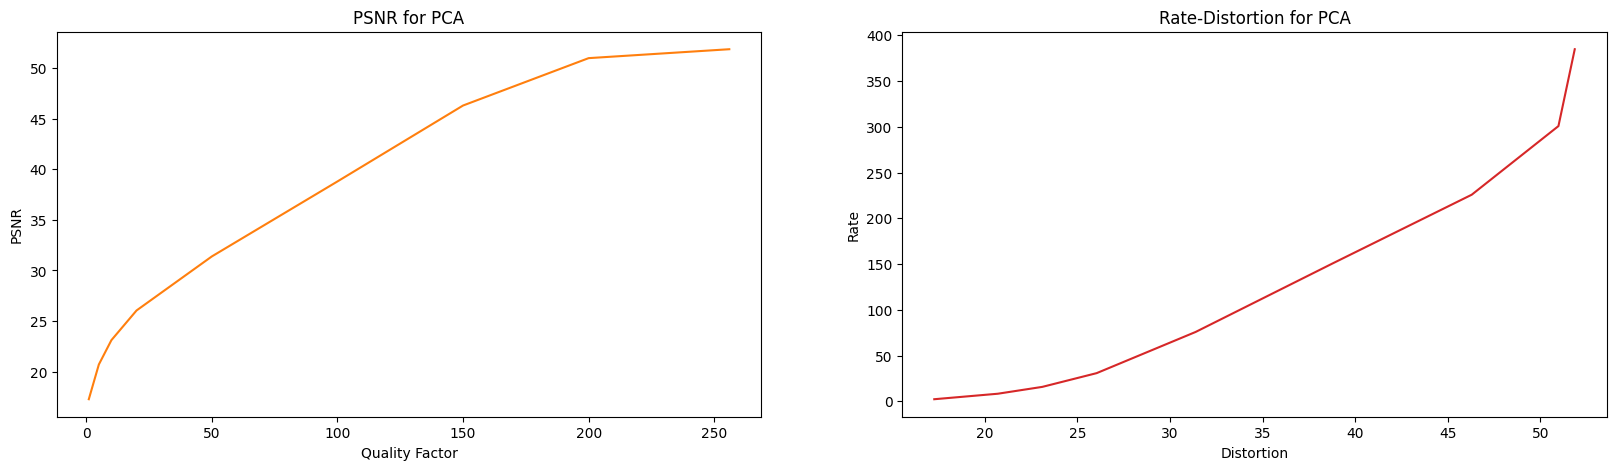

In [42]:
get_pca_metrics_graph()

<Figure size 640x480 with 0 Axes>

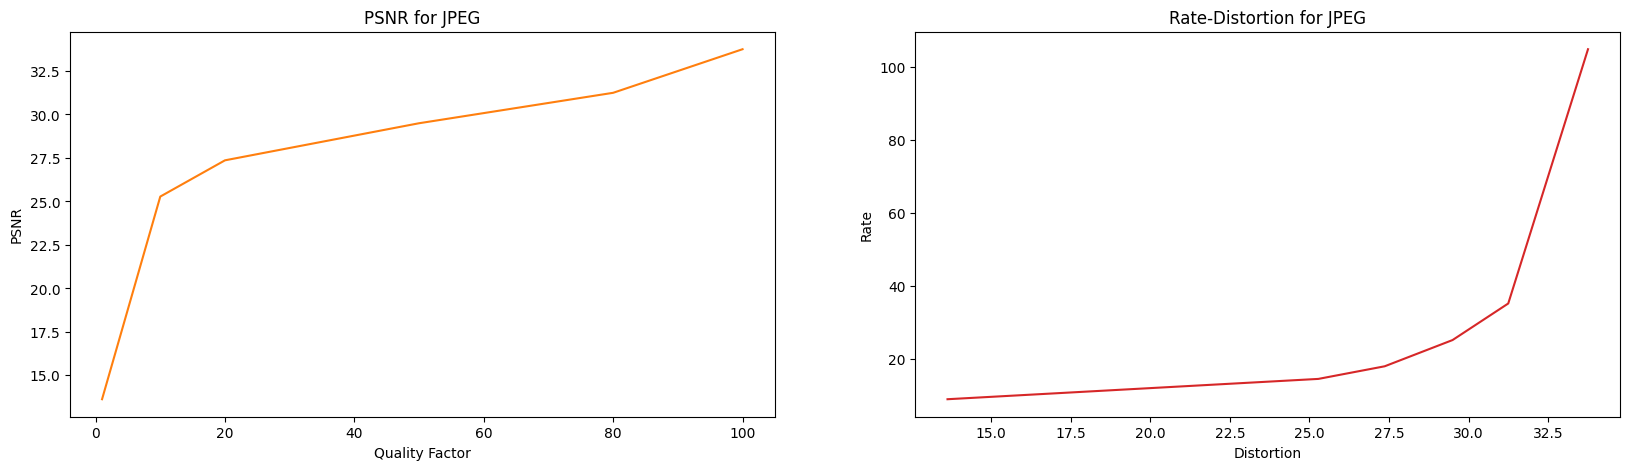

In [43]:
get_jpeg_metrics_graph()